In [1]:
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet
import lightning.pytorch as ptl

In [2]:

mvtseries = pd.read_csv(
    "../assets/daily_multivariate_timeseries.csv",
    parse_dates=["datetime"],
    index_col="datetime",
)

# mvtseries['Incoming Solar'].diff().plot()
mvtseries["target"] = (mvtseries["Incoming Solar"].diff() < -2000).astype(int)
mvtseries.tail()

,Incoming Solar,Wind Dir,Snow Depth,Wind Speed,Dewpoint,Precipitation,Vapor Pressure,Relative Humidity,Air Temp,target
datetime,,,,,,,,,,
2013-09-26,1034.2,137.083333,0.0,0.550000,1.645833,12.3,689.458333,0.970000,3.9,0
2013-09-27,2182.3,108.958333,0.0,0.608333,0.529167,0.0,634.625000,0.850000,8.3,0
2013-09-28,3384.5,97.250000,0.0,0.708333,0.670833,0.0,642.125000,0.606250,16.5,0
2013-09-29,478.2,108.666667,0.0,1.037500,2.129167,0.6,719.083333,0.486250,13.9,1
2013-09-30,2554.8,115.250000,0.0,0.962500,4.787500,2.0,863.416667,0.747083,12.2,0


In [3]:
class ExceedanceDataModule(ptl.LightningDataModule):
    def __init__(self, data: pd.DataFrame, test_size: float = 0.2, batch_size: int = 1):
        super().__init__()

        self.data = data
        self.var_names = self.data.columns.tolist()
        self.batch_size = batch_size
        self.test_size = test_size

        self.training = None
        self.validation = None
        self.test = None
        self.predict_set = None

    def setup(self, stage=None):
        self.data["target"] = (self.data["Incoming Solar"].diff() < -2000).astype(int)

        self.data["time_index"] = np.arange(self.data.shape[0])
        self.data["group_id"] = 0

        unique_times = self.data["time_index"].sort_values().unique()

        tr_ind, ts_ind = train_test_split(
            unique_times, test_size=self.test_size, shuffle=False
        )

        tr_ind, vl_ind = train_test_split(tr_ind, test_size=0.1, shuffle=False)

        training_df = self.data.loc[self.data["time_index"].isin(tr_ind), :]
        validation_df = self.data.loc[self.data["time_index"].isin(vl_ind), :]
        test_df = self.data.loc[self.data["time_index"].isin(ts_ind), :]

        self.training = TimeSeriesDataSet(
            data=training_df,
            time_idx="time_index",
            target="target",
            group_ids=["group_id"],
            max_encoder_length=14,
            max_prediction_length=7,
            time_varying_unknown_reals=self.var_names,
            scalers={k: StandardScaler() for k in self.var_names if k != "target"},
        )

        self.validation = TimeSeriesDataSet.from_dataset(self.training, validation_df)
        self.test = TimeSeriesDataSet.from_dataset(self.training, test_df)
        self.predict_set = TimeSeriesDataSet.from_dataset(
            self.training, self.data, predict=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        return self.validation.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return self.test.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return self.predict_set.to_dataloader(batch_size=1, shuffle=False)



In [4]:

datamodule = ExceedanceDataModule(data=mvtseries)

datamodule.setup()

x, y = next(iter(datamodule.train_dataloader()))

pprint(x)
pprint(y[0])


{'decoder_cat': tensor([], size=(1, 7, 0), dtype=torch.int64),
 'decoder_cont': tensor([[[-0.0706,  1.0593, -0.6419, -0.2414,  0.3052, -0.4286,  0.1476,
          -0.6920,  0.5924,  0.0000],
         [-0.5681,  1.7365, -0.6419, -0.2926,  0.2977,  0.2343,  0.1464,
           0.1674, -0.1971,  0.0000],
         [-1.4118,  1.8174, -0.6419, -1.0604,  0.3135,  3.8693,  0.1702,
           1.5024, -1.0805,  0.0000],
         [-1.3880,  0.6587, -0.6419, -1.1883,  0.2952,  0.4858,  0.1679,
           1.4987, -1.0053,  0.0000],
         [-1.4410,  1.5476, -0.6419,  0.5775,  1.4574,  3.0006,  1.6119,
           1.1317, -0.1783,  0.0000],
         [-0.7118,  2.4564, -0.6419,  0.8334,  0.1813,  1.9947,  0.0153,
           1.0250, -1.0147,  0.0000],
         [-0.1099,  1.4659, -0.6419, -0.5997, -0.0157, -0.4058, -0.1930,
           0.7085, -0.6388,  0.0000]]]),
 'decoder_lengths': tensor([7]),
 'decoder_target': tensor([[0, 0, 0, 0, 0, 0, 0]]),
 'decoder_time_idx': tensor([[14, 15, 16, 17, 18, 19, 2

/home/volody/code/study-py/ts-pytorch/.venv/lib/python3.13/site-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1712: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(


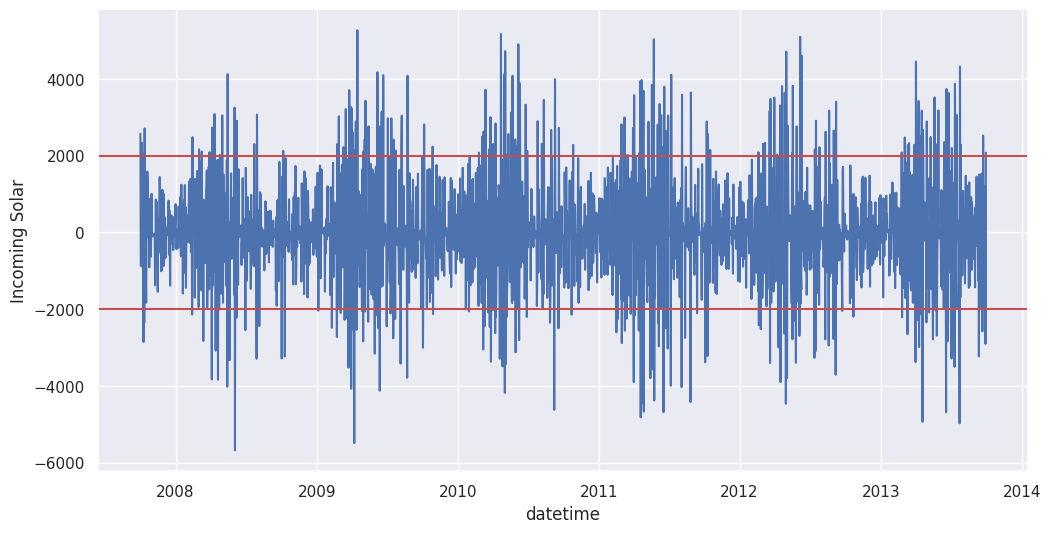

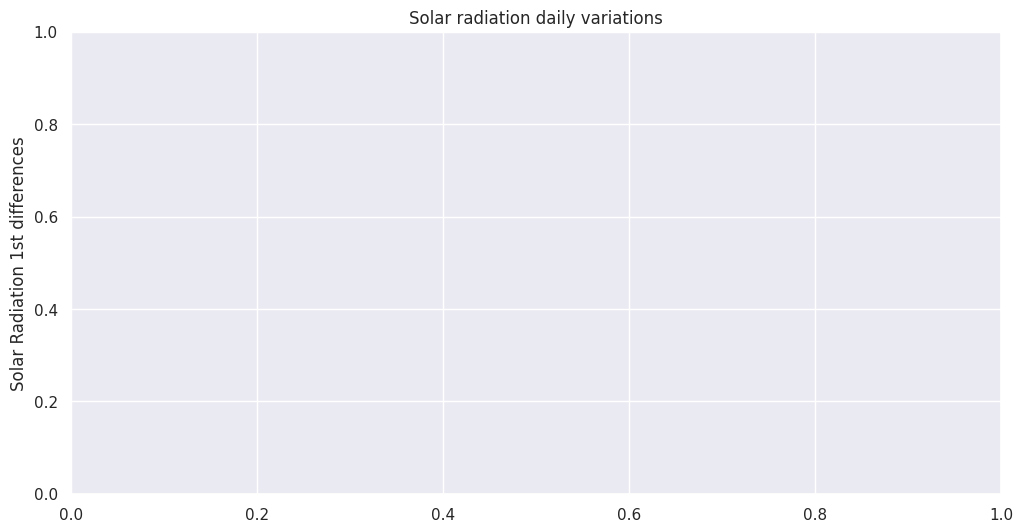

<Figure size 1200x600 with 0 Axes>

In [6]:
#
df = mvtseries["Incoming Solar"].diff().reset_index()

plt.rcParams["figure.figsize"] = [12, 6]
sns.set_theme(style="darkgrid")

sns.lineplot(x="datetime", y="Incoming Solar", data=df)
plt.axhline(y=-2000, color="r", linestyle="-")
plt.axhline(y=2000, color="r", linestyle="-")
plt.show()
plt.ylabel("Solar Radiation 1st differences")
plt.xlabel("")
plt.title("Solar radiation daily variations")
plt.show()

plt.savefig("../assets/time_series_plot_diff.png")
